In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf

In [49]:
#Stock Symbol Used : Alphabet A Inc - > Google 
# From 1 july 2021 to 30 June 2023
#This data is full collection of all stock features from Google's Stock Market
df_g = yf.download('GOOGL', start='2021-07-01', end='2023-07-01')

[*********************100%%**********************]  1 of 1 completed


In [50]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2021-07-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       503 non-null    float64
 1   High       503 non-null    float64
 2   Low        503 non-null    float64
 3   Close      503 non-null    float64
 4   Adj Close  503 non-null    float64
 5   Volume     503 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [51]:
df_g.describe()

,Open,High,Low,Close,Adj Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,118.874019,120.348290,117.455635,118.917678,118.917678,3.360941e+07
std,18.626035,18.522343,18.487173,18.496912,18.496912,1.375082e+07
min,85.400002,86.519997,83.339996,83.430000,83.430000,9.701400e+06
25%,102.395000,104.125000,101.385002,102.905003,102.905003,2.502870e+07
50%,117.089996,119.189499,116.110001,118.080002,118.080002,3.077400e+07
75%,136.280998,137.716248,135.263748,136.364006,136.364006,3.808445e+07
max,151.250000,151.546494,148.899002,149.838501,149.838501,1.232000e+08


In [52]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [53]:
df_g
#Indicating Number Of days and features -> 503 days and 6 stock features

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-01,121.724998,122.586998,121.531502,122.444504,122.444504,18110000
2021-07-02,123.150002,125.403999,123.059502,125.257500,125.257500,25982000
2021-07-06,125.648499,126.428001,124.582497,126.190002,126.190002,26404000
2021-07-07,127.162003,127.283997,126.153000,126.473999,126.473999,24060000
2021-07-08,124.026001,125.595497,124.022003,125.043999,125.043999,23790000
...,...,...,...,...,...,...
2023-06-26,120.760002,122.000000,118.269997,118.339996,118.339996,33969900
2023-06-27,117.080002,119.080002,116.099998,118.330002,118.330002,39535900
2023-06-28,117.089996,120.389999,116.849998,120.180000,120.180000,27091400


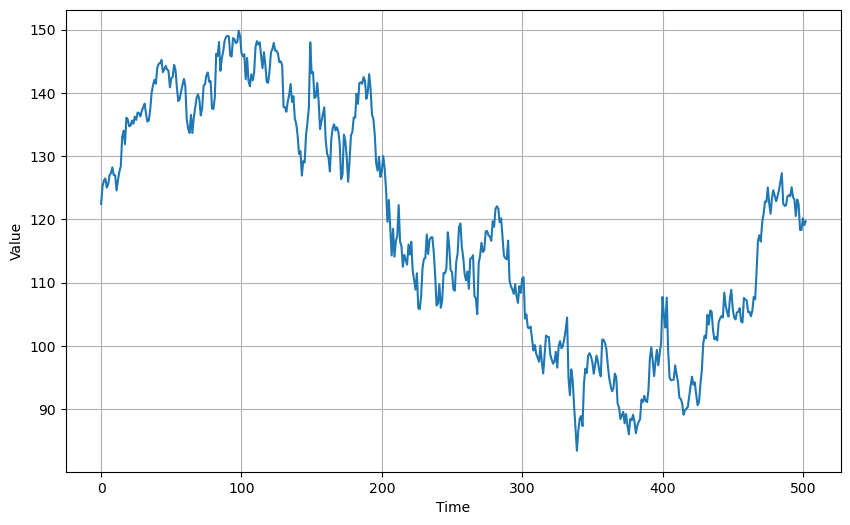

In [54]:

temps=[]
time_step=[]

step=0
for row in range(len(df_g)):
      time_step.append(step)
      step = step + 1

ds = np.array(df_g['Close'].values)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, ds)



In [55]:
ds_g = ds.reshape(-1,1)
print(ds_g.shape)

(503, 1)


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
series = scaler.fit_transform(ds_g)

In [57]:
503*0.85

427.55

In [58]:
split_time = 430
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [59]:
time_train.shape,x_train.shape

((430,), (430, 1))

In [60]:
time_valid.shape,x_valid.shape

((73,), (73, 1))

In [61]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [62]:
def windowed_valid_dataset(series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [63]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [64]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [65]:
print(train_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>


In [66]:
#Checking The Batches And their corresponding or respective label ,x and y 
for x,y in train_set:
    print("x :",x.numpy())
    print("y :",y.numpy())

x : [[[0.26442394]
  [0.26442394]
  [0.25614194]
  [0.24168597]
  [0.20404019]
  [0.17332122]
  [0.15479944]
  [0.14154817]
  [0.14877609]
  [0.18371137]
  [0.17527876]
  [0.11188327]
  [0.10284831]
  [0.07544218]
  [0.08417592]
  [0.09260865]
  [0.06520252]
  [0.08733826]
  [0.05963091]
  [0.03900098]
  [0.07559268]
  [0.07227995]
  [0.08568184]
  [0.07002118]
  [0.04171148]
  [0.05887794]
  [0.0691176 ]
  [0.07514095]
  [0.1218217 ]
  [0.11594897]]

 [[0.80077858]
  [0.81778697]
  [0.73949872]
  [0.70733414]
  [0.69845737]
  [0.66494495]
  [0.74178747]
  [0.76841823]
  [0.77741563]
  [0.76242487]
  [0.77010476]
  [0.75998562]
  [0.72997423]
  [0.64673199]
  [0.65766429]
  [0.75276504]
  [0.73784988]
  [0.69931557]
  [0.64029448]
  [0.68918884]
  [0.75066447]
  [0.75907457]
  [0.79350539]
  [0.79314396]
  [0.84986102]
  [0.82588067]
  [0.87552053]
  [0.87704139]
  [0.87376623]
  [0.88957727]]

 [[0.41758959]
  [0.34577654]
  [0.35064034]
  [0.3965532 ]
  [0.34037059]
  [0.35708532]
  

In [67]:
x[0],y[0]   #very First Set of batch of 30 values window and its respective 31st next value or label of first set..

(<tf.Tensor: shape=(30, 1), dtype=float64, numpy=
 array([[0.88198792],
        [0.89935773],
        [0.96131519],
        [0.97512355],
        [0.96687176],
        [0.97233779],
        [0.93958615],
        [0.91068157],
        [0.94883928],
        [0.91878308],
        [0.87782445],
        [0.8760474 ],
        [0.90413882],
        [0.94844775],
        [0.95599965],
        [0.97090724],
        [0.95254366],
        [0.95206183],
        [0.94521785],
        [0.92491178],
        [0.92701235],
        [0.9180979 ],
        [0.81834393],
        [0.81792988],
        [0.8069298 ],
        [0.8318136 ],
        [0.84787326],
        [0.87338963],
        [0.83057146],
        [0.84402597]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.79158542]])>)

In [68]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(train_set,epochs=100)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(430, 1)


Epoch 1/100
2/2 [==============================] - 3s 150ms/step - loss: 3.2259 - mae: 3.6866
Epoch 2/100
2/2 [==============================] - 0s 80ms/step - loss: 3.3862 - mae: 3.8168
Epoch 3/100
2/2 [==============================] - 0s 77ms/step - loss: 3.2214 - mae: 3.7188
Epoch 4/100
2/2 [==============================] - 0s 90ms/step - loss: 0.9138 - mae: 1.3701
Epoch 5/100
2/2 [==============================] - 0s 93ms/step - loss: 1.9482 - mae: 2.4413
Epoch 6/100
2/2 [==============================] - 0s 94ms/step - loss: 0.2700 - mae: 0.5896
Epoch 7/100
2/2 [==============================] - 0s 95ms/step - loss: 0.6473 - mae: 1.0405
Epoch 8/100
2/2 [==============================] - 0s 113ms/step - loss: 0.2615 - mae: 0.6027
Epoch 9/100
2/2 [==============================] - 0s 149ms/step - loss: 0.3884 - mae: 0.7994
Epoch 10/100
2/2 [==============================] - 0s 96ms/step - loss: 0.2517 - mae: 0.5905
Epoch 11/100
2/2 [==============================] - 0s 79ms/step -

In [69]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [70]:
window_size1 = 64
batch_size1 = 256

In [71]:
window_size1 = 64
batch_size1 = 256
pd=model_forecast(model,series,window_size1)

14/14 [==============================] - 1s 14ms/step


In [72]:
pd.shape

(440, 64, 1)

In [73]:
#Valid Data Starts From Split time index :,look back days = window size , i.e., it will look back 64 days earlier and will predict 65 day onwards predictions
pd=pd[split_time - window_size1:-1, -1, 0]

In [74]:
pd.shape  #We are going to get next 606 days prediction

(73,)

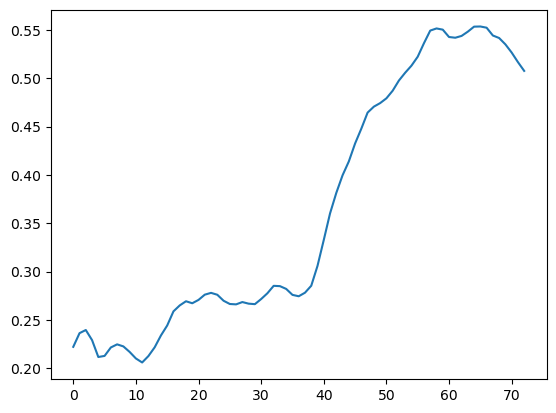

In [75]:
plt.plot(pd)

In [76]:
time_valid   # Last 600 days

array([430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502])

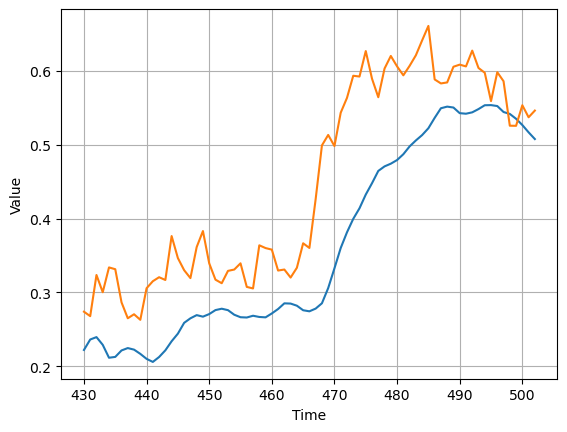

In [77]:
plot_series(time_valid,pd)
plot_series(time_valid, x_valid)

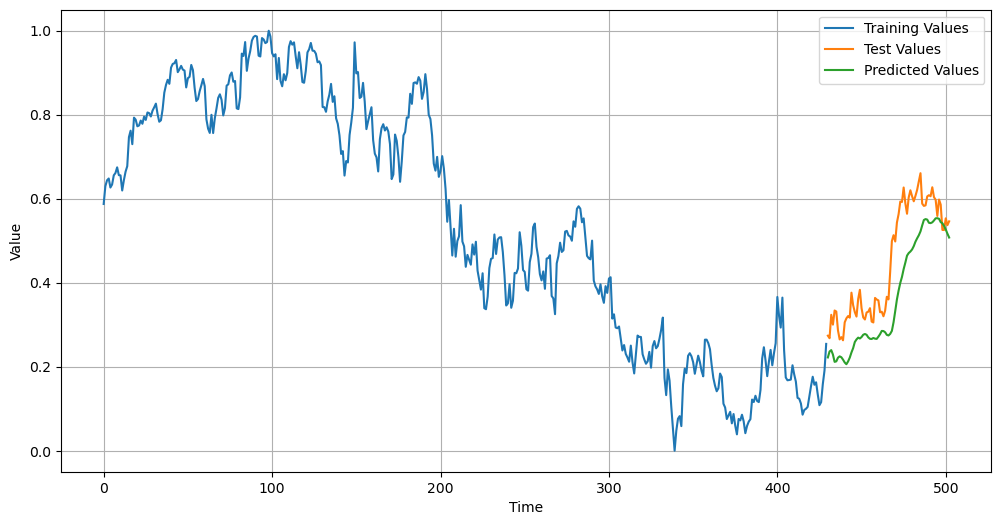

In [78]:
plt.figure(figsize=(12,6))
plot_series(time_train,x_train)
plot_series(time_valid, x_valid)
plot_series(time_valid,pd)
plt.legend(['Training Values','Test Values','Predicted Values'])

In [79]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size1:-1, -1, 0]

14/14 [==============================] - 0s 12ms/step


In [80]:
print(rnn_forecast.shape)
print(x_valid.shape)
y=np.array(x_valid)
print(x_valid.shape)

(73,)
(73, 1)
(73, 1)


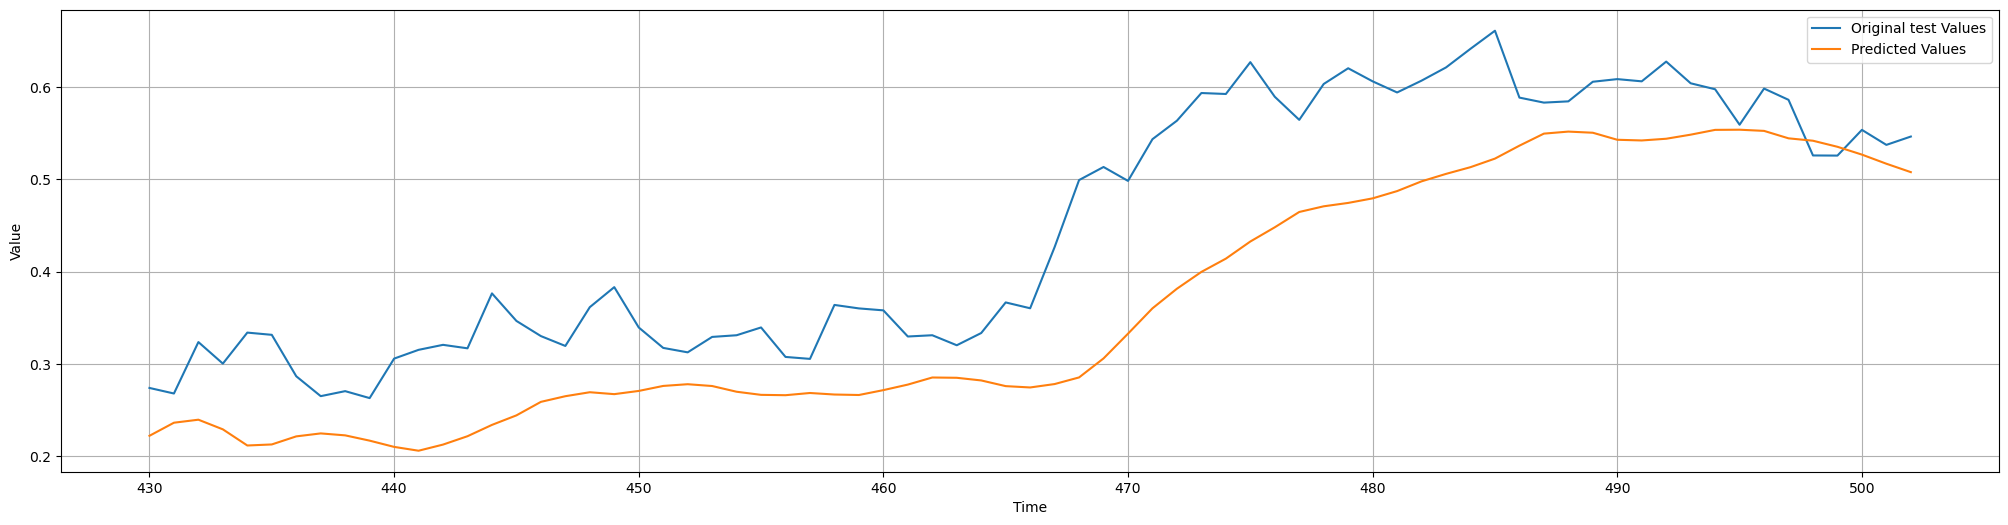

In [81]:
plt.figure(figsize=(25, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.legend(['Original test Values','Predicted Values'])

In [82]:
#Beyond Future Forecasting :

In [89]:
#Experiment -1 : For Next 80 days :
df_test = yf.download('GOOGL', start='2023-07-01', end='2023-10-25')

[*********************100%%**********************]  1 of 1 completed


In [90]:
df_test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-03,119.239998,120.190002,118.820000,119.900002,119.900002,14467900
2023-07-05,119.239998,122.610001,119.230003,121.750000,121.750000,27584800
2023-07-06,119.800003,120.300003,118.400002,120.110001,120.110001,24745200
2023-07-07,120.099998,121.050003,119.400002,119.480003,119.480003,21692600
2023-07-10,118.300003,118.309998,116.139999,116.449997,116.449997,35315200
...,...,...,...,...,...,...
2023-10-18,139.449997,140.720001,137.380005,137.960007,137.960007,23375000
2023-10-19,138.500000,139.660004,137.380005,137.750000,137.750000,26066000
2023-10-20,137.330002,137.869995,135.080002,135.600006,135.600006,26315200


In [91]:
len(df_test)

80

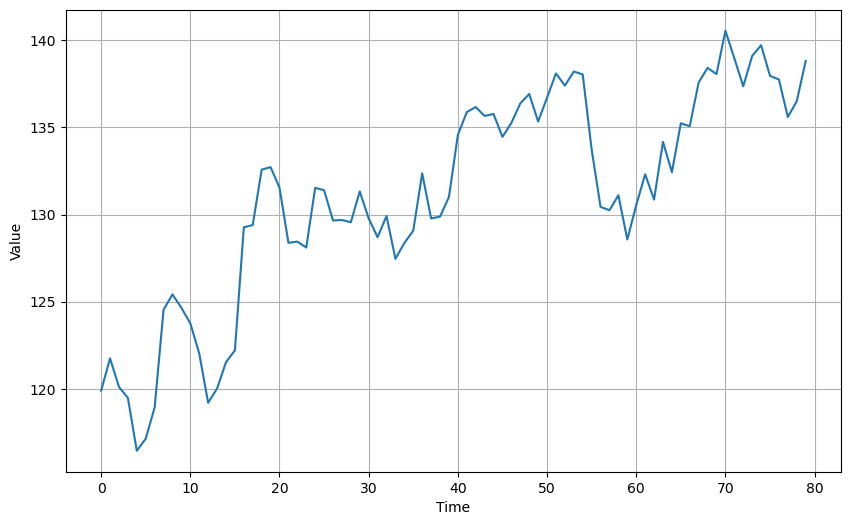

In [92]:
new_time_step=[]
for i in range(df_test.shape[0]):
  new_time_step.append(i)

close_data=df_test['Close']
new_time = np.array(new_time_step)
plt.figure(figsize=(10, 6))
plot_series(new_time,close_data)

In [93]:
x_test=close_data
x_test=np.array(x_test).reshape(-1,1)

In [94]:
scaler1=MinMaxScaler(feature_range=(0,1))
x=scaler1.fit_transform(x_test)
x

array([[0.14315368],
       [0.21991708],
       [0.15186733],
       [0.12572638],
       [0.        ],
       [0.0286308 ],
       [0.10290468],
       [0.33568473],
       [0.37219913],
       [0.34024907],
       [0.30331964],
       [0.23153529],
       [0.11410785],
       [0.14813273],
       [0.2107884 ],
       [0.23900418],
       [0.53195038],
       [0.53734414],
       [0.66929464],
       [0.67510374],
       [0.62655611],
       [0.49502095],
       [0.49792519],
       [0.48381746],
       [0.62572606],
       [0.62033167],
       [0.54813292],
       [0.54937768],
       [0.54398329],
       [0.61742743],
       [0.55311197],
       [0.50829863],
       [0.55892107],
       [0.45684645],
       [0.49460561],
       [0.52406646],
       [0.66058067],
       [0.55311197],
       [0.5572616 ],
       [0.60414912],
       [0.75186746],
       [0.80622419],
       [0.8182571 ],
       [0.79709551],
       [0.80165985],
       [0.74730312],
       [0.78049763],
       [0.826

In [95]:
len(x)

80

In [96]:
x.dtype

dtype('float64')

In [97]:
window_size1=20
d=model_forecast(model,x,window_size1)
da=d[len(d)-window_size1:-1,-1,0]
da

2/2 [==============================] - 0s 10ms/step


array([0.6228046 , 0.6134835 , 0.606659  , 0.609167  , 0.632364  ,
       0.63300586, 0.6542775 , 0.6586    , 0.6935831 , 0.71601564,
       0.7387863 , 0.7714259 , 0.779601  , 0.7807231 , 0.7845117 ,
       0.7944283 , 0.8002824 , 0.8000482 , 0.79465127], dtype=float32)

In [98]:
len(d)

61

In [99]:
len(da)

19

Text(0.5, 1.0, 'prediction for next 19 days')

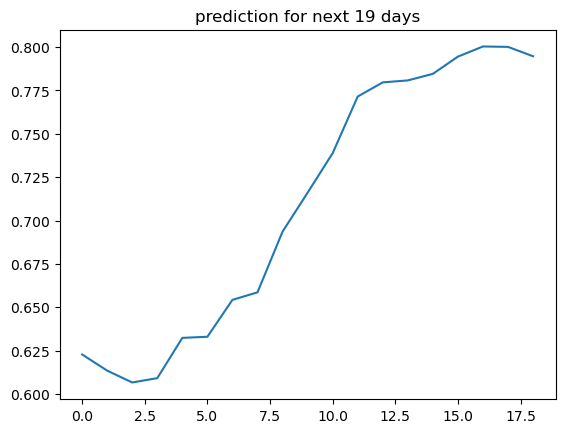

In [100]:
plt.plot(np.arange(0,len(da)),da)
plt.title('prediction for next {} days'.format(len(da)))

In [101]:
window_size=20
batch_size=256
test_val=model_forecast(model,x,window_size)
test_vals=test_val.reshape(-1,1)
test_vals.shape

2/2 [==============================] - 0s 9ms/step


(1220, 1)

In [102]:

results=[]
for i in range(len(test_vals)):
    if(i%(window_size+1)==0):
          results.append(test_vals[i])
len(results)

59

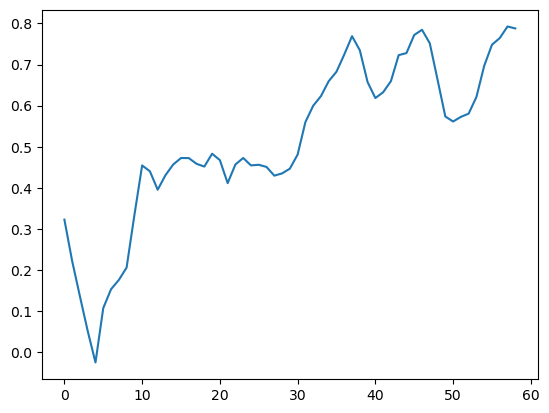

In [103]:
plt.plot(results)

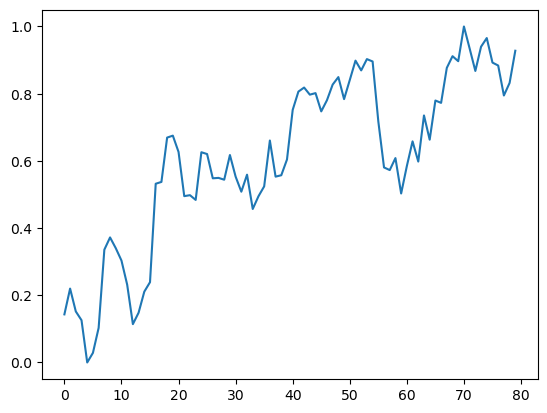

In [104]:
plt.plot(x)

In [105]:
time=np.arange(0,len(df_test))

In [106]:
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [107]:
pred_time=np.arange(len(df_test),len(df_test)+len(results))

In [108]:
pred_time

array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138])

Text(0.5, 1.0, 'Prediction for next 59 days')

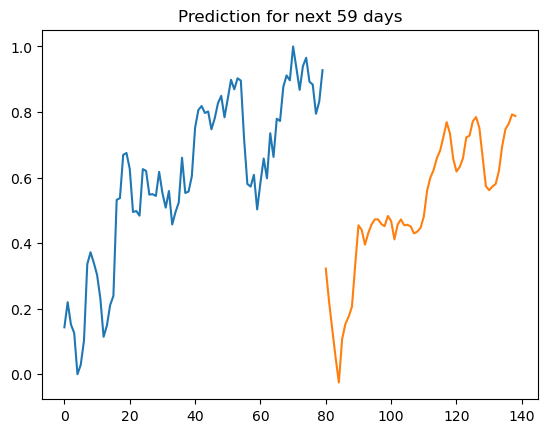

In [109]:
plt.plot(time,x)
plt.plot(pred_time,results)
plt.title('Prediction for next {} days'.format(len(results)))